In [3]:
!pip install lpips

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import torch
import numpy as np
import torch.nn as nn
import kaggle
import matplotlib.pyplot as plt
import pandas as pd
import os
from torch.utils.data import Dataset,DataLoader
!chmod 600 /root/.kaggle/kaggle.json
from torchvision.io import read_image
from torchvision.transforms import CenterCrop
from math import sqrt
import tqdm
import lpips
import requests
import PIL.Image as Image

#config
LR=10E-4
BATCH_SIZE=16

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
!kaggle datasets download  --force -d hsankesara/flickr-image-dataset

100% 8.16G/8.16G [06:58<00:00, 22.9MB/s]
100% 8.16G/8.16G [06:58<00:00, 20.9MB/s]


In [6]:
!unzip /content/flickr-image-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/5354911151.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/535529555.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/5356236664.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/5356318668.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/535830521.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/5359437945.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/5361355399.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/53614287.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/536147209.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/5361551308.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/536156200.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/

In [1]:
# pour monter son drive Google Drive local
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import sys

my_local_drive='/content/gdrive/My Drive/Colab Notebooks/mini-dalle/'
# Ajout du path pour les librairies, fonctions et données
sys.path.append(my_local_drive)
# Se positionner sur le répertoire associé
%cd $my_local_drive

/content/gdrive/My Drive/Colab Notebooks/mini-dalle


In [4]:
ls -lh

total 56M
-rw------- 1 root root  47M Apr 26 20:11 firstSave.pth
-rw------- 1 root root 2.3M Apr 27 10:21 vq-vae.ipynb
-rw------- 1 root root 6.5M Apr 10 23:29 vq-vae_mnist.ipynb


#DATASET

In [9]:
class Flickr8k(Dataset):
    def __init__(self,transform=None, target_transform=None):
        self.img_labels = pd.read_csv("/content/flickr30k_images/results.csv",sep='|')
        self.unique_img_labels = self.img_labels.loc[self.img_labels[" comment_number"]==' 0']
        self.img_dir = "/content/flickr30k_images/flickr30k_images"
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self,unique=True):
        return len(self.unique_img_labels if unique else self.img_labels)

    def __getitem__(self, idx,unique=True):
        img_path = os.path.join(self.img_dir,
                                self.unique_img_labels.iloc[idx, 0] if unique 
                                else self.unique_img_labels.iloc[idx, 0])
        image = CenterCrop((333,333))(read_image(img_path)).float().to(device)/255.
        label = (self.img_labels if not unique else self.unique_img_labels).iloc[idx, 2]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

    def get_batch(self,batch_size,shuffle=False):
      indices = list(range(batch_size)) if not shuffle else np.random.randint(0,self.__len__(),batch_size)
      elements = [self.__getitem__(idx)[0] for idx in indices],[self.__getitem__(idx)[1] for idx in indices]
      return torch.stack(elements[0]).to(device),elements[1]

In [10]:
#plot some images
data = Flickr8k()
dataloader = DataLoader(data,batch_size=BATCH_SIZE,shuffle=True)


plt.figure(figsize=(25,25))
for i in range(1,10):
  continue
  random_id = np.random.randint(0,len(data))
  plt.subplot(3,3,i)
  plt.imshow(np.array(torch.moveaxis(data[random_id ][0],0,-1).cpu()))
  plt.title(data[random_id ][1].replace(" t","\nt"),fontsize=10)

<Figure size 2500x2500 with 0 Axes>

In [11]:
class ConvBlock(nn.Module):
  def __init__(self,in_chan):
    super().__init__()
    self.operations = nn.Sequential(
        nn.Conv2d(in_chan,256,4,2,1,padding_mode="reflect"),
        nn.LeakyReLU()
    )

  def forward(self,x):
    return self.operations(x)

In [12]:
class ResBlock(nn.Module):
  def __init__(self):
    super().__init__()
    self.operations = nn.Sequential(
        nn.LeakyReLU(),
        nn.Conv2d(256,256,3,1,1,padding_mode="reflect"),
        nn.BatchNorm2d(256),
        nn.LeakyReLU(),
        nn.Conv2d(256,256,1,1,0,padding_mode="reflect"),
        nn.BatchNorm2d(256)
    )

  def forward(self,x):
    return self.operations(x)+x

In [13]:
#vector quantizer : takes in C*W*H out of the encoder, and outputs 
class VectorQuantizer(nn.Module):
  def __init__(self,nb_vectors,size_vectors):
    super().__init__()
    self.nb_vectors = nb_vectors
    self.size_vectors = size_vectors
    self.codes = torch.rand((nb_vectors,size_vectors),requires_grad=True).to(device)#uniform distribution

  def forward(self,x):
    #note that n_channels must be the same as n_vectors 
    batch_size = x.shape[0]#for reshaping at the end
    width = x.shape[2]#for reshaping at the end
    x = x.permute(0,2,3,1).flatten(end_dim=2)#(batchsize*w*h,n_channels)(each pixel stack through the channels becomes a code)
    #get the L2 sums matrix
    x_big = x[None,:].expand(self.nb_vectors,-1,-1)#expanding to nb_vectors replicas of the encoder codes vector (thus size nb_vectors,batchsize*w*h,n_channels)
    #expanding to nb_vectors matrices of size (batchsize*w*h), each containing replicas of one n_channels-long code.
    expanded_codes = self.codes[None,:].expand(len(x),-1,-1).permute(1,0,2)
    L2 = ((x_big - expanded_codes)**2).sum(dim=2)
    #get the argmin
    amin = L2.argmin(dim=0)
    #replace by list of the codes
    codes =torch.stack([self.codes[i] for i in amin])
    #return the codebook as well as the two losses
    loss1 = nn.MSELoss()(codes,x.detach())
    loss2 = nn.MSELoss()(codes.detach(),x)
    #copy the gradient graph emplacement
    codes = x + (codes-x).detach()
    #bring back to original order and shape
    codes = codes.reshape(batch_size,width,width,self.size_vectors).permute(0,3,1,2)
    return codes,loss1,loss2

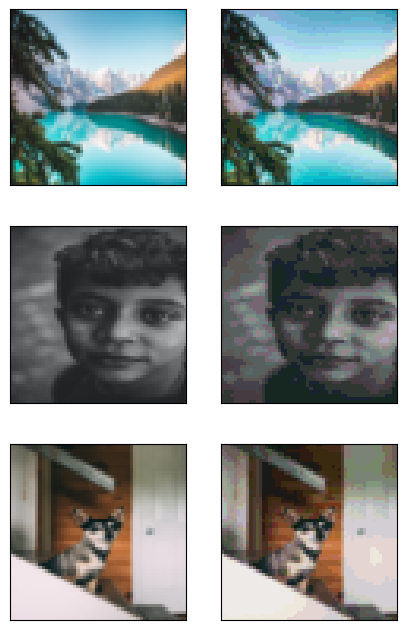

In [14]:
#sanity checks on the quantizer : a (56*56,3) codebook is akin to quantizing pixels, let's look at some resulting images
urls = ["https://images.pexels.com/photos/2662116/pexels-photo-2662116.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=2",
        "https://images.pexels.com/photos/2108843/pexels-photo-2108843.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=2",
        "https://images.pexels.com/photos/3090875/pexels-photo-3090875.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=2"]
#get some images
images_in = [np.array(Image.open(requests.get(url, stream=True).raw).resize((56,56),Image.BILINEAR)) for url in urls]
images = torch.stack([torch.tensor(im).permute(2,0,1).to(device) for im in images_in])/256.
#init the quantizer
vq = VectorQuantizer(56*56,3)
images_out = vq(images)[0].permute(0,2,3,1).cpu()
#print before and after quantization
plt.figure(figsize=(5,8))
for i in range(1,7,2):
  plt.subplot(3,2,i)
  plt.gca().xaxis.set_visible(False)
  plt.gca().yaxis.set_visible(False)
  plt.imshow(images_in[int((i-1)/2)])
  plt.subplot(3,2,i+1)
  plt.gca().xaxis.set_visible(False)
  plt.imshow(images_out[int((i-1)/2)])
  plt.gca().yaxis.set_visible(False)

In [15]:
class Model(nn.Module):
  def __init__(self,nb_vectors,size_vectors,beta):
    super().__init__()
    #encoder
    self.encoder = nn.Sequential(
        ConvBlock(3),
        ConvBlock(256),
        ResBlock(),
        ConvBlock(256),
        ResBlock(),
        ConvBlock(256),
        ResBlock(),
        ResBlock(),
        VectorQuantizer(nb_vectors,size_vectors)
    )

    #decoder
    self.decoder = nn.Sequential(
        ResBlock(),
        ResBlock(),
        nn.LeakyReLU(),
        nn.ConvTranspose2d(256,256,4,2,0),
        nn.BatchNorm2d(256),
        ResBlock(),
        nn.LeakyReLU(),
        nn.ConvTranspose2d(256,256,4,2,1),
        nn.BatchNorm2d(256),
        ResBlock(),
        nn.LeakyReLU(),
        nn.ConvTranspose2d(256,256,4,2,2),
        nn.BatchNorm2d(256),
        ResBlock(),
        nn.LeakyReLU(),
        nn.ConvTranspose2d(256,3,3,2,0),
        nn.Sigmoid()
    )
    self.beta = beta

  def forward(self,x):
    x,l1,l2 = self.encoder(x)
    x = self.decoder(x)
    return x,self.beta*l1,self.beta*l2
  def encode(self,x):
    return self.encoder(x)

In [16]:
model = Model(20*20,256,2.).to(device)
model.load_state_dict(torch.load("firstSave.pth"))
#sanity check : passing the codes to the quantization gives back the codes (output of this line is 0).
print(torch.max(model.encoder[-1](model.encoder[-1].codes.t().reshape(1,256,20,20))[0] - model.encoder[-1].codes.t().reshape(1,256,20,20)))
#output and input size are the same
model(data.get_batch(2)[0].to(device))[0].shape

tensor(0., device='cuda:0', grad_fn=<MaxBackward1>)


torch.Size([2, 3, 333, 333])

In [17]:
def plot_images():
  plt.figure(figsize=(5,25))
  for i in range(1,20,2):
    random_id = np.random.randint(0,len(data))
    plt.subplot(10,2,i)
    plt.imshow(np.array(torch.moveaxis(data[random_id][0].cpu(),0,-1)))
    plt.subplot(10,2,i+1)
    pred = model(data[random_id][0].reshape(1,3,333,333))[0][0].cpu().detach()
    plt.imshow(torch.moveaxis(pred,0,-1))
  plt.show()

In [18]:
def train_the_model(model,data,loss,opt,n_epochs):
  l0_iterations=[]
  l1_iterations=[]
  l2_iterations=[]
  iter_ctr = 0
  for i in range(n_epochs):
    pbar = tqdm.tqdm(data)
    for batch in pbar:
      pred,l1,l2 = model(batch[0].float())
      l0 = loss(pred,batch[0].float()).sum()

      opt.zero_grad()
      (l0+l1+l2).backward()
      opt.step()

      l0_iterations.append(l0.item())
      l1_iterations.append(l1.item())
      l2_iterations.append(l2.item())
      pbar.set_description(f"l0 : {l0_iterations[-1]}"+
                           f", l1 : {l1_iterations[-1]}"+
                           f", l2 : {l2_iterations[-1]}")
      iter_ctr+=1
      if iter_ctr>100:
        plot_images()
        iter_ctr=0
  return l0_iterations,l1_iterations,l1_iterations

In [19]:
loss = lpips.LPIPS(net='alex').to(device)
batch = train_the_model(model,dataloader,loss,torch.optim.Adam(model.parameters(),lr=LR),2)

Output hidden; open in https://colab.research.google.com to view.

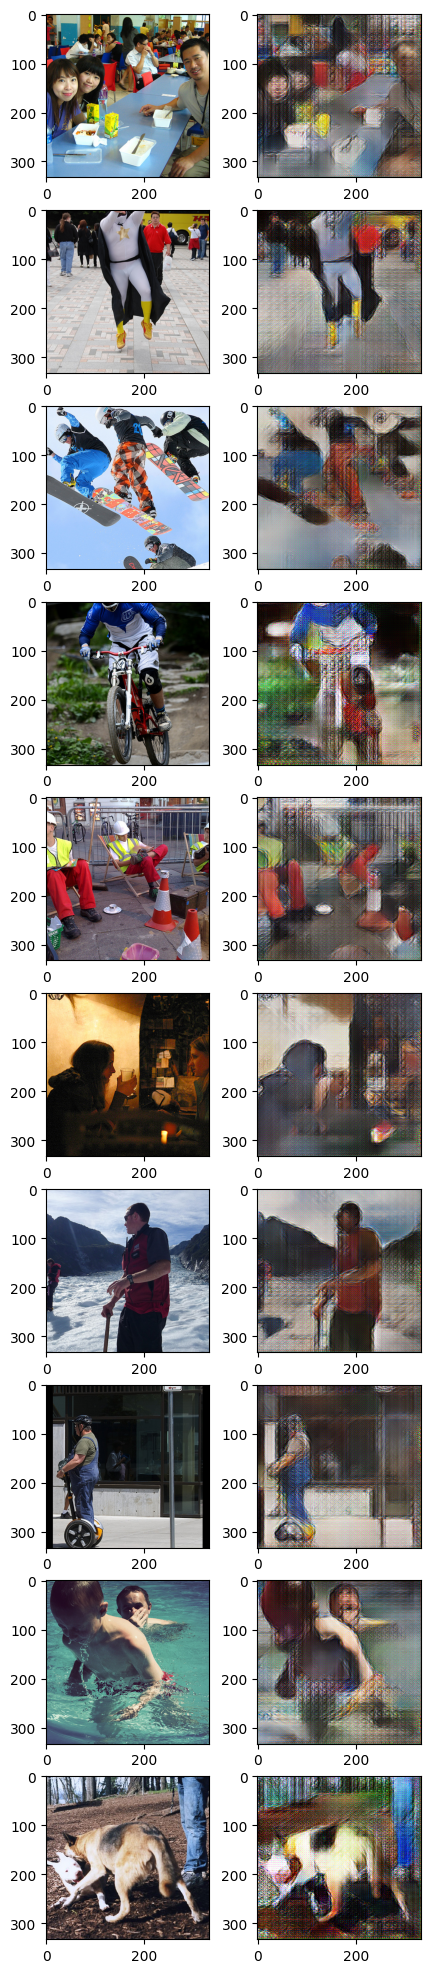

In [20]:
plot_images()

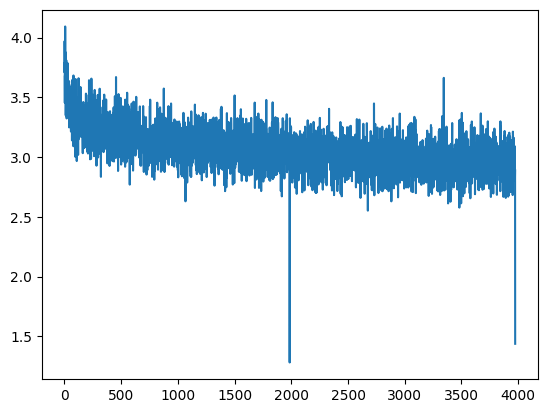

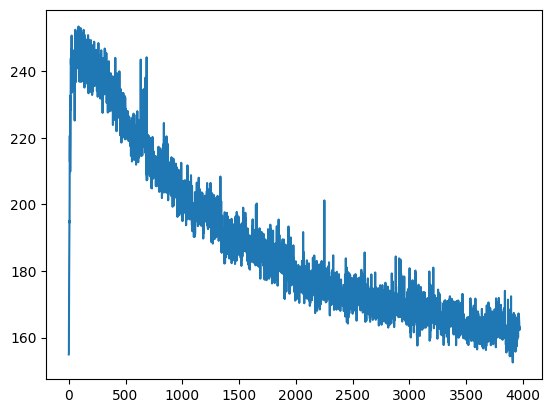

In [21]:
plt.plot(range(len(batch[0])),batch[0])
plt.show()
plt.plot(range(len(batch[0])),batch[1])
plt.show()

#save model

In [22]:
torch.save(model.state_dict(),"firstSave.pth")